In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import itertools
import math
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.metrics import accuracy_score #scoring

In [2]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
# Define the classes of interest: airplane, bird, cat
classes_of_interest = [0, 2, 3]  # airplane: 0, bird: 2, cat: 3
class_names = {0: 'airplane', 2: 'bird', 3: 'cat'}

In [4]:
# Function to plot images of a specific class
def plot_class_images(X, Y, class_label, class_name, num_images=10):
    class_indices = np.where(Y == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_images, replace=False)
    selected_images = X[selected_indices]

    plt.figure(figsize=(15, 2))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Images of {class_name}')
    plt.show()

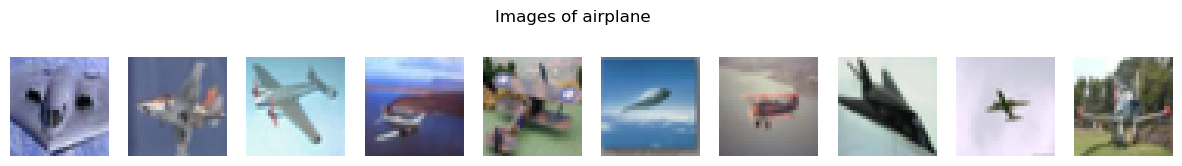

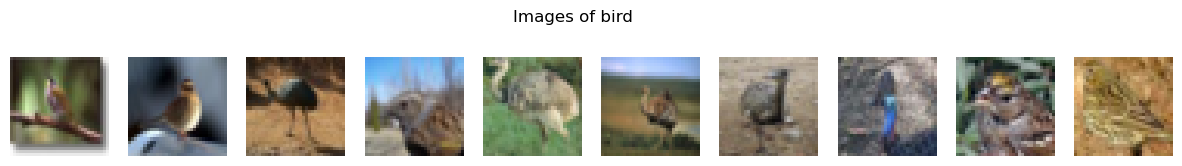

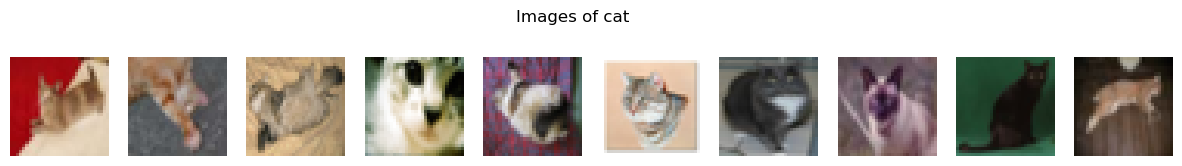

In [5]:
# Plot images of each class
for class_label in classes_of_interest:
    plot_class_images(X_train.reshape(-1, 32, 32, 3), y_train, class_label, class_names[class_label])

In [6]:
# Sample data (replace with your actual X_train data)
X_train = np.random.rand(3000, 32, 32, 3)
X_test = np.random.rand(3000, 32, 32, 3)

# Reshape data to flatten each image into a feature vector
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_train.shape[0], -1)

# reshape the test data
X_test_reshaped = X_test_reshaped[:500]
y_test = y_test[:500]

print(f"shape of X_train : {X_train_reshaped.shape}")
print(f"shape of X_test : {X_test_reshaped.shape}")

shape of X_train : (3000, 3072)
shape of X_test : (500, 3072)


In [7]:
X_train_reshaped = np.round(X_train_reshaped, decimals = 2)
X_test_reshaped = np.round(X_test_reshaped, decimals = 2)

In [8]:
print(f"New X_train_reshaped : {X_train_reshaped}")

New X_train_reshaped : [[0.24 0.26 0.6  ... 0.92 0.43 0.07]
 [0.55 0.93 0.28 ... 0.41 0.29 1.  ]
 [0.18 0.07 0.3  ... 0.68 0.89 0.42]
 ...
 [0.96 0.31 0.45 ... 0.04 0.68 0.92]
 [0.16 0.46 0.26 ... 0.94 0.62 0.27]
 [0.94 0.25 0.41 ... 0.46 0.42 0.65]]


In [9]:
print(f"New X_test_reshaped : {X_test_reshaped}")

New X_test_reshaped : [[0.4  0.57 0.15 ... 0.79 0.8  0.58]
 [0.25 0.03 0.72 ... 0.42 0.87 0.85]
 [0.45 0.93 0.94 ... 0.36 0.13 0.1 ]
 ...
 [0.55 0.53 0.9  ... 0.34 0.04 0.63]
 [0.9  0.2  0.52 ... 0.12 0.1  0.88]
 [0.27 0.41 0.87 ... 0.03 0.89 0.52]]


In [10]:
def jaccard_distance(vec1, vec2, threshold=0.5):
    """
    Computes the Jaccard distance between two vectors.
    The value returned is between 0 and 1, inclusively. A value of 1 indicates
    no overlap between two vectors, whereas a value of 0 indicates complete overlap.
    
    :param vec1: iterable of float values
    :param vec2: iterable of float values
    :param threshold: threshold to binarize the vectors
    :return: the Jaccard distance value
    """
    if len(vec1) != len(vec2):
        raise ValueError("Vectors must be of the same length")
    
    binarized_vec1 = [1 if x > threshold else 0 for x in vec1]
    binarized_vec2 = [1 if x > threshold else 0 for x in vec2]
    
    n11 = n10 = n01 = 0
    for i in range(len(binarized_vec1)):
        if binarized_vec1[i] == 1 and binarized_vec2[i] == 1:
            n11 += 1
        elif binarized_vec1[i] == 1 and binarized_vec2[i] == 0:
            n10 += 1
        elif binarized_vec1[i] == 0 and binarized_vec2[i] == 1:
            n01 += 1

    denominator = n11 + n10 + n01
    if denominator == 0:
        # Handle the edge case where there is no overlap
        return 1.0 if (n11 + n10 + n01 == 0) else 0.0
    
    return 1 - float(n11) / denominator

# Example usage
# data = np.random.rand(5000, 3072)
# vec1 = data[0]
# vec2 = data[1]

# print(jaccard_distance(vec1, vec2))

In [11]:
def ceil_to_decimals(number, decimals=2):
    factor = 10 ** decimals
    return math.ceil(number * factor) / factor

In [12]:
# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil_to_decimals(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [13]:
# Best Matching Unit search
def find_bmu(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = jaccard_distance(som[row][col], data[t])
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

In [14]:
# Data Normalisation
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

In [18]:
def fit(train_x, num_rows, num_cols, max_m_dsitance, max_learning_rate, max_steps):
    train_x_norm = minmax_scaler(train_x) # normalisation

    # initialising self-organising map
    num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
    np.random.seed(40)
    som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

    # start training iterations
    for step in range(max_steps):
      if (step+1) % 1000 == 0:
        print("Iteration: ", step+1) # print out the current iteration for every 1k
      learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

      t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
      winner = find_bmu(train_x_norm, t, som, num_rows, num_cols)
      for row in range(num_rows):
        for col in range(num_cols):
          if jaccard_distance([row,col],winner) <= neighbourhood_range:
            som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

    print("SOM training completed")
    return t, som

In [19]:
# hyper parameters
num_rows = 10
num_cols = 10
max_m_dsitance = 4
max_learning_rate = 0.5
max_steps = int(1*10e3)

t, som = fit(X_train_reshaped, num_rows, num_cols, max_m_dsitance, max_learning_rate, max_steps)

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
SOM training completed


In [26]:
def predict(test_x, test_y, t, som, num_rows, num_cols):
    # test data

    data = minmax_scaler(test_x) # normalisation

    winner_labels = []
    for t in range(data.shape[0]):
        winner = find_bmu(data, t, som, num_rows, num_cols)
        row = winner[0]
        col = winner[1]
        predicted = label_map[row][col]
        winner_labels.append(predicted)

    print("Accuracy", accuracy_score(test_y, np.array(winner_labels)))

In [27]:
predict(X_test_reshaped, y_test, t, som, num_rows, num_cols)

NameError: name 'label_map' is not defined

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
(1000, 32, 32, 3)
(1000, 32, 32, 3)


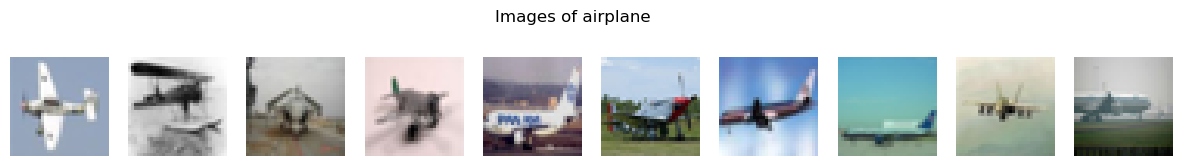

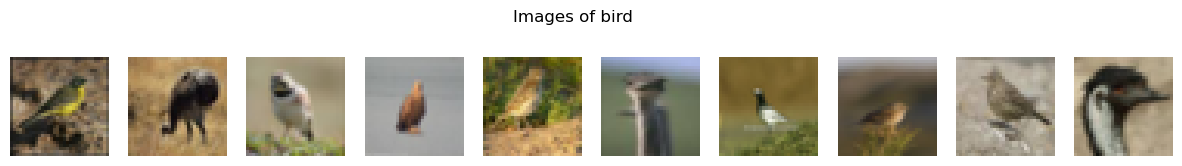

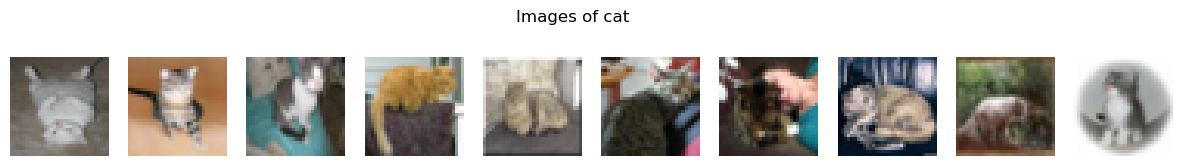

(1000, 3072)
(1000, 3072)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# Define the classes of interest: airplane, bird, cat
classes_of_interest = [0, 2, 3]  # airplane: 0, bird: 2, cat: 3
class_names = {0: 'airplane', 2: 'bird', 3: 'cat'}

# Function to filter and limit dataset to 1000 samples per class
def filter_and_limit_data(X, Y, classes, limit_per_class):
    filtered_X = []
    filtered_Y = []
    for class_label in classes:
        class_indices = np.where(Y == class_label)[0][:limit_per_class]
        filtered_X.append(X[class_indices])
        filtered_Y.append(Y[class_indices])
    return np.vstack(filtered_X), np.vstack(filtered_Y)


# Filter and limit training data
X_train, Y_train = filter_and_limit_data(X_train, Y_train, classes_of_interest, 334)

# Filter and limit testing data
X_test, Y_test = filter_and_limit_data(X_test, Y_test, classes_of_interest, 334)

# Adjust to exactly 1000 samples
X_train = X_train[:1000]
Y_train = Y_train[:1000]
X_test = X_test[:1000]
Y_test = Y_test[:1000]

print(X_train.shape)
print(X_test.shape)

# Preprocess images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Function to plot images of a specific class
def plot_class_images(X, Y, class_label, class_name, num_images=10):
    class_indices = np.where(Y == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_images, replace=False)
    selected_images = X[selected_indices]

    plt.figure(figsize=(15, 2))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Images of {class_name}')
    plt.show()

# Plot images of each class
for class_label in classes_of_interest:
    plot_class_images(X_train.reshape(-1, 32, 32, 3), Y_train, class_label, class_names[class_label])


# Flatten images
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)
print(X_train.shape)  # should output (1000, 3072)
print(X_test.shape)   # should output (1000, 3072)


In [ ]:
class SOM:
    def __init__(self, m, n, dim, learning_rate=0.5, radius=None, decay_function=None):
        self.m = m
        self.n = n
        self.dim = dim
        self.learning_rate = learning_rate
        self.radius = radius if radius else max(m, n) / 2
        self.decay_function = decay_function if decay_function else self._default_decay(self.learning_rate, self.radius, )
        self.weights = np.random.random((m, n, dim))
        self.initial_radius = self.radius

    def _default_decay(self, learning_rate, radius, i, max_iter):
        return learning_rate * np.exp(-i / max_iter), radius * np.exp(-i / max_iter)

    def _find_bmu(self, sample):
        distances = np.linalg.norm(self.weights - sample, axis=2)
        bmu_idx = np.unravel_index(np.argmin(distances), (self.m, self.n))
        return bmu_idx

    def _update_weights(self, sample, bmu_idx, learning_rate, radius):
        for i in range(self.m):
            for j in range(self.n):
                weight = self.weights[i, j, :]
                dist_to_bmu = np.linalg.norm(np.array([i, j]) - np.array(bmu_idx))
                if dist_to_bmu < radius:
                    influence = np.exp(-(dist_to_bmu**2) / (2 * (radius**2)))
                    self.weights[i, j, :] += influence * learning_rate * (sample - weight)

    def train(self, data, num_iterations):
        for i in range(num_iterations):
            for sample in data:
                bmu_idx = self._find_bmu(sample)
                learning_rate, radius = self.decay_function(self.learning_rate, self.initial_radius, i, num_iterations)
                self._update_weights(sample, bmu_idx, learning_rate, radius)
            if i % 10 == 0:
                print(f"Iteration {i}/{num_iterations} complete")

    def map_vects(self, data):
        bmu_indices = np.array([self._find_bmu(sample) for sample in data])
        return bmu_indices

# Define SOM dimensions and parameters
som = SOM(m=32, n=32, dim=32*32*3, learning_rate=0.5, radius=5)

# Train SOM
som.train(X_train, num_iterations=80)

# Map training and testing data to BMU indices
train_bmu_indices = som.map_vects(X_train)
test_bmu_indices = som.map_vects(X_test)

print("Training data mapped to BMU indices")
print(train_bmu_indices)
print("Testing data mapped to BMU indices")
print(test_bmu_indices)


In [ ]:
def get_cluster_counts(som, data):
    bmu_indices = som.map_vects(data)
    unique_bmus, counts = np.unique(bmu_indices, axis=0, return_counts=True)
    return counts

train_cluster_counts = get_cluster_counts(som, X_train)
test_cluster_counts = get_cluster_counts(som, X_test)

# Print cluster counts with commas
print("Training Data Cluster Counts:", ", ".join(map(str, train_cluster_counts)))
print("Testing Data Cluster Counts:", ", ".join(map(str, test_cluster_counts)))
def plot_som_clusters(som, data, title):
    cluster_info = []
    plt.figure(figsize=(10, 10))
    for x in range(som.m):
        for y in range(som.n):
            plt.text(x, y, '', ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.5, lw=0))
    
    bmu_indices = som.map_vects(data)
    unique_bmus = np.unique(bmu_indices, axis=0)
    
    for bmu in unique_bmus:
        points = data[(bmu_indices == bmu).all(axis=1)]
        cluster_info.append(f"{bmu[0]},{bmu[1]}:{len(points)}")
        plt.text(bmu[1], bmu[0], str(len(points)),
                 ha='center', va='center',
                 bbox=dict(facecolor='red', alpha=0.5, lw=0))
    
    plt.title(title)
    plt.xlim(-0.5, som.n-0.5)
    plt.ylim(-0.5, som.m-0.5)
    plt.gca().invert_yaxis()
    plt.show()
    
    return cluster_info

train_clusters = plot_som_clusters(som, X_train, "SOM Clusters for Training Data")
test_clusters = plot_som_clusters(som, X_test, "SOM Clusters for Testing Data")

# Print cluster information
# print("Training Data Clusters:", ", ".join(train_clusters))
# print("Testing Data Clusters:", ", ".join(test_clusters))

In [ ]:
def calculate_accuracy(labels, bmu_indices):
    cluster_labels = {}
    for idx, bmu in enumerate(bmu_indices):
        bmu_tuple = tuple(bmu)
        if bmu_tuple not in cluster_labels:
            cluster_labels[bmu_tuple] = []
        cluster_labels[bmu_tuple].append(labels[idx])
    
    correct_predictions = 0
    total_predictions = len(labels)
    
    for bmu, label_list in cluster_labels.items():
        most_common_label = np.bincount(np.array(label_list).flatten()).argmax()
        correct_predictions += (np.array(label_list).flatten() == most_common_label).sum()
    
    accuracy = correct_predictions / total_predictions
    return accuracy

train_accuracy = calculate_accuracy(Y_train, train_bmu_indices)
test_accuracy = calculate_accuracy(Y_test, test_bmu_indices)

print(f"Training data accuracy: {train_accuracy}")
print(f"Testing data accuracy: {test_accuracy}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(train_x, train_y), (test_x, test_y) = cifar10.load_data()
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# Define the classes of interest: airplane, bird, cat
classes_of_interest = [0, 2, 3]  # airplane: 0, bird: 2, cat: 3
class_names = {0: 'airplane', 2: 'bird', 3: 'cat'}

# Function to filter and limit dataset to 1000 samples per class
def filter_and_limit_data(X, Y, classes, limit_per_class):
    filtered_X = []
    filtered_Y = []
    for class_label in classes:
        class_indices = np.where(Y == class_label)[0][:limit_per_class]
        filtered_X.append(X[class_indices])
        filtered_Y.append(Y[class_indices])
    return np.vstack(filtered_X), np.vstack(filtered_Y)

# Filter and limit training data
train_x, train_y = filter_and_limit_data(train_x, train_y, classes_of_interest, 334)

# Filter and limit testing data
test_x, test_y = filter_and_limit_data(test_x, test_y, classes_of_interest, 334)

# Adjust to exactly 1000 samples
train_x = train_x[:1000]
train_y = train_y[:1000]
test_x = test_x[:1000]
test_y = test_y[:1000]

print(train_x.shape)
print(test_x.shape)

# Preprocess images
train_x = train_x.astype('float32') / 255.0
test_x = test_x.astype('float32') / 255.0

# Function to plot images of a specific class
def plot_class_images(X, Y, class_label, class_name, num_images=10):
    class_indices = np.where(Y == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_images, replace=False)
    selected_images = X[selected_indices]

    plt.figure(figsize=(15, 2))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Images of {class_name}')
    plt.show()

# Plot images of each class
for class_label in classes_of_interest:
    plot_class_images(X_train.reshape(-1, 32, 32, 3), train_y, class_label, class_names[class_label])


# Flatten images
train_x = train_x.reshape(-1, 32 * 32 * 3)
test_x = test_x.reshape(-1, 32 * 32 * 3)
print(train_x.shape)  # should output (1000, 3072)
print(test_x.shape)   # should output (1000, 3072)

print("*"*20)
print("Y_train:",Y_train, end = " ,")
print("Y_test:",Y_test, end = " ,")


In [ ]:


# Normalize images
def normalize_images(data):
    data = data.astype('float32') / 255.0
    data = data.reshape(data.shape[0], -1)  # Flatten the images
    return data

train_x_norm = normalize_images(train_x)
test_x_norm = normalize_images(test_x)

# Print shapes for verification
print(train_x_norm.shape, train_y.shape, test_x_norm.shape, test_y.shape)

# Helper functions

# Euclidean distance
def e_distance(x, y):
    return distance.euclidean(x, y)

# Manhattan distance
def m_distance(x, y):
    return distance.cityblock(x, y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
    winner = [0, 0]
    shortest_distance = np.sqrt(data.shape[1])  # initialize with max distance
    input_data = data[t]
    for row in range(num_rows):
        for col in range(num_cols):
            dist = e_distance(som[row][col], data[t])
            if dist < shortest_distance:
                shortest_distance = dist
                winner = [row, col]
    return winner

# Learning rate and neighborhood range calculation
def decay(step, max_steps, max_learning_rate, max_m_distance):
    coefficient = 1.0 - (np.float64(step) / max_steps)
    learning_rate = coefficient * max_learning_rate
    neighborhood_range = ceil(coefficient * max_m_distance)
    return learning_rate, neighborhood_range

# Hyperparameters
num_rows = 30
num_cols = 30
max_m_distance = 5
max_learning_rate = 0.5
max_steps = int(7.5 * 10e3)

# Initializing self-organizing map
num_dims = train_x_norm.shape[1]  # number of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims))  # map construction

# Start training iterations
for step in range(max_steps):
    if (step + 1) % 1000 == 0:
        print("Iteration: ", step + 1)  # print out the current iteration for every 1k
    learning_rate, neighborhood_range = decay(step, max_steps, max_learning_rate, max_m_distance)

    t = np.random.randint(0, high=train_x_norm.shape[0])  # random index of training data
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    for row in range(num_rows):
        for col in range(num_cols):
            if m_distance([row, col], winner) <= neighborhood_range:
                som[row][col] += learning_rate * (train_x_norm[t] - som[row][col])  # update neighbor's weight

print("SOM training completed")
# Collecting labels

label_data = train_y
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
    for col in range(num_cols):
        map[row][col] = []  # empty list to store the label

for t in range(train_x_norm.shape[0]):
    if (t + 1) % 1000 == 0:
        print("Sample data: ", t + 1)
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    map[winner[0]][winner[1]].append(label_data[t])  # label of winning neuron

# Construct label map
label_map = np.zeros(shape=(num_rows, num_cols), dtype=np.int64)
for row in range(num_rows):
    for col in range(num_cols):
        label_list = map[row][col]
        if len(label_list) == 0:
            label = 10  # out of range label for empty neuron
        else:
            label = max(label_list, key=label_list.count)
        label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:grey'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

# Test data

# Using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data = test_x_norm  # normalization

winner_labels = []

for t in range(data.shape[0]):
    winner = winning_neuron(data, t, som, num_rows, num_cols)
    row = winner[0]
    col = winner[1]
    predicted = label_map[row][col]
    winner_labels.append(predicted)

print("Accuracy: ", accuracy_score(test_y, np.array(winner_labels)))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# Define the classes of interest: airplane, bird, cat
classes_of_interest = [0, 2, 3]  # airplane: 0, bird: 2, cat: 3
class_names = {0: 'airplane', 2: 'bird', 3: 'cat'}

# Function to filter and limit dataset to 1000 samples per class
def filter_and_limit_data(X, Y, classes, limit_per_class):
    filtered_X = []
    filtered_Y = []
    for class_label in classes:
        class_indices = np.where(Y == class_label)[0][:limit_per_class]
        filtered_X.append(X[class_indices])
        filtered_Y.append(Y[class_indices])
    return np.vstack(filtered_X), np.vstack(filtered_Y)

# Filter and limit training data
X_train, Y_train = filter_and_limit_data(X_train, Y_train, classes_of_interest, 334)

# Filter and limit testing data
X_test, Y_test = filter_and_limit_data(X_test, Y_test, classes_of_interest, 334)

# Adjust to exactly 1000 samples
X_train = X_train[:1000]
Y_train = Y_train[:1000]
X_test = X_test[:1000]
Y_test = Y_test[:1000]

print(X_train.shape)
print(X_test.shape)

# Preprocess images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Flatten images
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)
print(X_train.shape)  # should output (1000, 3072)
print(X_test.shape)   # should output (1000, 3072)
